# Arctic Amplification

Arctic amplification is the phenomenon whereby as a response to global warming, the surface air temperatures over the higher latitudes increase more than the lower latitudes. This is shown in the below figure:

<img src="https://matthewjhenry.github.io/images/cmip5_PA.png" width="800">

## Water vapour variation

A possible factor affecting this is that global warming arises from the increased concentration of the greenhouse gases carbon dioxide and methane. These are both well mixed in the atmosphere so their concentrations are the same at all latitudes. On the other hand, water vapour shows a considerable reduction in concentration at higher latitudes, as shown below.

<img src="https://apollo.nvu.vsc.edu/classes/met130/notes/chapter4/graphics/specific_hum.jpg" width="300">

## OLR

To investigate this further, let us see how the outgoing long wave radiation at the top of the atmosphere varies with carbon dioxide and methane with different water vapour concentrations.

In [1]:
import warnings
warnings.filterwarnings("ignore") # ignore all warnings in this notebook
import matplotlib.pyplot as plt;
from Model.radiation.base import round_any;
import Model.radiation.real_gas_data.hitran as hitran;
import Model.radiation.real_gas_data.specific_humidity as humidity;
from Model.radiation.real_gas_data.temperature_profiles import earth_temp, fixed_tropopause_temp;
from Model.radiation.real_gas import RealGas, transmission, B_wavenumber, optical_depth;
from IPython.display import HTML;
import numpy as np
p_toa = 0.1  # Top of atmosphere pressure for this notebook (Pa)
n_bands = 200 # number of wavenumber bands in this notebook

In [2]:
def get_q_args_list(atmos, molecule_to_change, scale_factors):
    if scale_factors[0] != 1:
        raise ValueError('Initial composition not 1')
    q_args = atmos.q_funcs_args.copy()
    base_compos = list(q_args.copy()[molecule_to_change])[0]
    other_args = q_args[molecule_to_change][1:]
    q_args = []
    q_labels = []
    for i in range(len(scale_factors)):
        q_args.append(atmos.q_funcs_args.copy())
        q_args[i][molecule_to_change] = (base_compos*scale_factors[i], *other_args)
        if scale_factors[i] > 10000:
            label = "{:.1e}".format(scale_factors[i])
        elif scale_factors[i] < 1:
            label = "{:.3f}".format(scale_factors[i])
        else:
            label = "{:.0f}".format(scale_factors[i])
        q_labels.append(label)
    return q_args, q_labels


def update_flux(atmos, q_args, T_func):
    atmos.q_funcs_args = q_args
    T_interface = T_func(atmos.p_interface)
    atmos.tau_interface = optical_depth(atmos.p_interface[:, 0], T_interface, atmos.nu,
                                        atmos.molecule_names, atmos.q_funcs, atmos.q_funcs_args)
    atmos.up_flux, atmos.down_flux = atmos.get_flux()
    atmos.net_flux = np.sum(atmos.up_flux * atmos.nu_bands['delta'], axis=1) - \
                        np.sum(atmos.down_flux * atmos.nu_bands['delta'], axis=1) 
    
def varying_compos_olr(atmos, q_args_list, T_func):
    """For each composition given by q_args_list, OLR found"""
    area_under_curve = []
    for j in range(len(q_args_list)):
        update_flux(atmos, q_args_list[j], T_func)
        area_under_curve.append(np.trapz(atmos.up_flux[0, :], atmos.nu_bands['centre']))
    update_flux(atmos, q_args_list[0], T_func)  # return to initial value
    return area_under_curve

def molecule_multiplier_from_co2(molecule, co2_mult):
    # finds scale factor to initial molecule concentration to give same increase in mass as was applied with a co2 multiplier
    # I.e. if needed for the question we add y kg of molecule instead of y kg of CO2, what is the warming?
    surface_base_ppmv = {'CO2': 370.0, 'CH4': 1.75, 'H2O': 20000, 'O3': 7.9}
    mass_co2_added = (co2_mult * surface_base_ppmv['CO2'] - surface_base_ppmv['CO2']) * humidity.molecules['CO2']['M']
    eqv_ppmv_molecule_added = mass_co2_added / humidity.molecules[molecule]['M']
    molecule_ppmv_total = surface_base_ppmv[molecule] + eqv_ppmv_molecule_added
    molecule_mult = molecule_ppmv_total / surface_base_ppmv[molecule]
    return molecule_mult

def ghg_diff_initial_h2o_plot(ax, atmos, h2o_scale_factors, ghg_molecule, co2_multipliers, T_func):
    """plots how OLR changes wit increasing greenhouse gas concentration 
    for different h2o initial concentrations"""
    q_initial_arg_list, h2o_labels = get_q_args_list(atmos, 'H2O', h2o_scale_factors)
    ghg_scale_factors = molecule_multiplier_from_co2(ghg_molecule, co2_multipliers)
    for i in range(len(q_initial_arg_list)):
        update_flux(atmos, q_initial_arg_list[i], T_func)
        q_ghg_arg_list, _ = get_q_args_list(atmos, ghg_molecule, ghg_scale_factors)
        tot_flux = varying_compos_olr(atmos, q_ghg_arg_list, T_func)
        ax.plot(co2_multipliers, np.array(tot_flux)-tot_flux[0], label=h2o_labels[i])
    update_flux(atmos, q_initial_arg_list[0], T_func)  # return to initial value
    ax.legend(title="Initial multiple of\n$H_2O$ concentration")
    ax.set_ylabel('Change in Outgoing Flux (W/m$^2$))');
    ax.set_xlabel('Multiple of initial $CO_2$ Concentration');
    return ax

def plot_absorption(ax=None, xlim=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(18,6))
    hitran.plot_absorption_coefficient('CO2', hitran.p_reference, 270, ax)
    hitran.plot_absorption_coefficient('CH4', hitran.p_reference, 270, ax)
    hitran.plot_absorption_coefficient('H2O', hitran.p_reference, 270, ax)
    hitran.plot_absorption_coefficient('O3', hitran.p_reference, 270, ax)
    ax.set_title('Absorption Coefficient at 270K, 101320 Pa');
    ax.legend(labels=['CO2', 'CH4', 'H2O', 'O3']);
    if xlim is not None:
        ax.set_xlim(xlim);

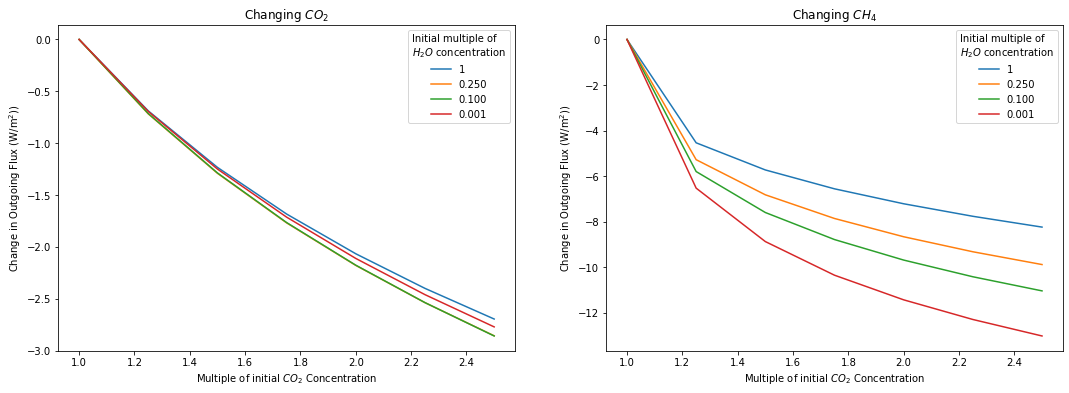

In [3]:
earth_atmos = RealGas(nz='auto', ny=1, molecule_names=['CO2', 'CH4', 'H2O', 'O3'],
                      p_toa=p_toa, T_func=earth_temp, n_nu_bands=n_bands)
fig, axs = plt.subplots(1,2, figsize=(18,6), sharex=True)
h2o_scales = [1,0.25,0.1,0.001]
co2_scales = np.linspace(1.0, 2.5, 7)
axs[0] = ghg_diff_initial_h2o_plot(axs[0], earth_atmos, h2o_scales, "CO2", co2_scales, earth_temp)
axs[1] = ghg_diff_initial_h2o_plot(axs[1], earth_atmos, h2o_scales, "CH4", co2_scales, earth_temp)
axs[0].set_title("Changing $CO_2$");
axs[1].set_title("Changing $CH_4$");

## Interpretation 

The above plot shows the effect of increasing $CO_2$ and $CH_4$ on the outgoing radiation for an earth-like atmosphere with differing $H_2O$ concentrations. I.e. lower $H_2O$ concentration refers to a higher latitude. The temperature profile of the atmosphere is kept constant independent of the changing composition. 

The x-axis is the same as in the Real Gas Radiation 2 notebook i.e. when changing $CH_4$, multiple of $CO_2$ concentration of 1.2 means the addition of a mass of $CH_4$ such that the equivalent mass of $CO_2$ would increase the $CO_2$ concentration to 1.2 times its initial value.

From these plots, we see that for a given mass of greenhouse gas, $CH_4$ reduces the OLR by a greater amount and thus leads to greater heating. This is due to the saturation effect described in Real Gas Radiation 2.

Also from the plots, we see that in general, a reduction in $H_2O$ concentration causes the same amount of greenhouse gas to cause a greater reduction in the outgoing flux. 

It is helpful to look at the OLR spectrum and the absorption coefficients to understand this. From this, we see that at the wavenumbers where $CO_2$ is dominant (around 700 $cm^{-1}$) and where $CH_4$ is dominant (around 1300 $cm^{-1}$), there is also significant absorption from water vapour. So a reduction in water vapour concentration means that there is more radiation to be absorbed by the greenhouse gases - the greenhouse gases become more potent. I.e. $CH_4$ is more potent than $CO_2$ because the wavenumber region where it dominates is less saturated. Equally, $CH_4$ at a location with less water vapour is more potent than $CH_4$ at a location with more water vapour because the wavenumber region where it dominates is less saturated.

The fact that for a given reduction in $H_2O$, the potency of $CH_4$ increases more than the potency of $CO_2$ is because the starting saturation is less in this wavenumber region and possibly because the absorption coefficient of $H_2O$ is greater here too. It is interesting to note though, that ozone has greater absorption than $H_2O$ in the region where $CO_2$ dominates. This overlap also reduces the potency of $CO_2$ as a greenhouse gas. For $CO_2$, we also see that the potency decreases when $H_2O$ concentration changes from 0.1 to 0.001 (green to red), whereas for $CH_4$, we see a increase in potency as expected. I am not sure why this happens.

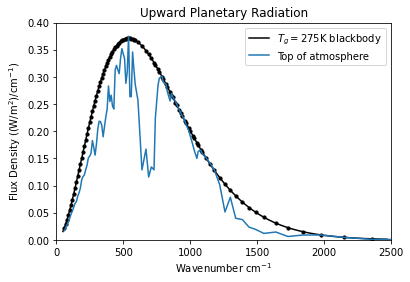

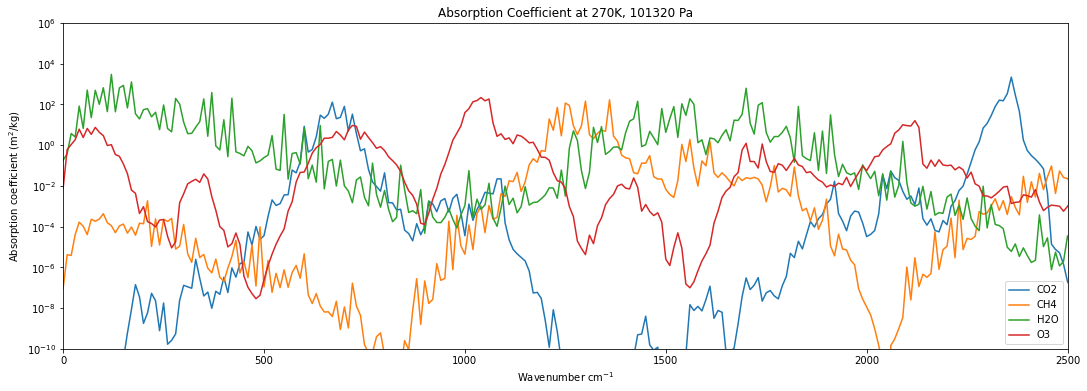

In [4]:
earth_atmos.plot_olr()
plot_absorption(xlim=(0,2500))